In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/data/preprocessed_ids2018_subset_after_research_Bot.csv")
print("Loaded dataset shape:", df.shape)

# Use a subset for faster hyperparameter tuning (e.g. 20%)
df = df.sample(frac=0.2, random_state=42)
print("Subset shape for tuning:", df.shape)

# Split into features (X) and labels (y)
X = df.drop(columns=['Label'])
y = df['Label']

# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded dataset shape: (1048575, 21)
Subset shape for tuning: (209715, 21)
X_train: (167772, 20) X_test: (41943, 20)


In [11]:
# # GridSearchCV systematically tests combinations of hyperparameters.

# # Initialize Random Forest
# rf = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1,
#     max_depth=20,          # cap depth
#     max_features='sqrt',   # default, faster
#     bootstrap=True         # standard setting
# )

# # Define hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Grid search to find best parameters
# # Randomized search (tries only a subset of combinations)
# search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=5,          # try 5 random combos instead of 27
#     scoring='f1',
#     cv=3,              # 3-fold cross-validation
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

# This systematically tries every parameter combination using 3-fold cross-validation and chooses the best based on F1 score, which balances false positives and false negatives, which is critical for intrusion detection.

# Cross-validation evaluates model on multiple splits, giving a more reliable estimate of performance.
# Using F1-score as scoring ensures the model balances precision and recall, important for IDS (we don’t want to miss attacks).





# RandomForestClassifier is robust for IDS (handles high-dimensional, noisy data well).
# RandomForestClassifier is a robust ensemble algorithm, suitable for IDS because it handles high-dimensional data and is resilient to noise.

# Initialize Random Forest
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_features='sqrt',
    bootstrap=True
)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# n_estimators: number of trees. More trees usually improve accuracy but increase compute.
# max_depth: controls how deep trees grow. Limiting depth prevents overfitting.
# min_samples_split: minimum samples required to split a node; increasing this reduces overfitting.


# Use RandomizedSearchCV (faster than GridSearchCV)
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,            # only 5 random combinations
    scoring='f1',
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("RandomizedSearchCV initialized (5 random combos × 3 folds)")



RandomizedSearchCV initialized (5 random combos × 3 folds)


In [12]:
# # Train the model
# grid_search.fit(X_train, y_train)

# # Get the best estimator
# best_rf = grid_search.best_estimator_
# print("\nBest hyperparameters:", grid_search.best_params_)
# # Extracts the best-performing Random Forest found by the search.
# # Trains RF for every combination in param_grid and cross-validation folds.
# # Returns the best-performing model.

# # Tip: If computation is too heavy, we can use RandomizedSearchCV to sample a subset of parameter combinations.


# # Predict on test data
# y_pred = best_rf.predict(X_test)
# # The trained model predicts whether each test record is an attack (1) or benign (0).

# # save the trained model for later reuse
# joblib.dump(best_rf, "best_random_forest_model.pkl")

# # later load it again without retraining:
# # rf_loaded = joblib.load("best_random_forest_model.pkl")


# # Train the model
start = time.time()

print("Starting RandomizedSearchCV training...")
search.fit(X_train, y_train)

print("\nSearch completed in {:.2f} minutes".format((time.time() - start) / 60))
print("Best hyperparameters found:", search.best_params_)

# Get the best model
best_rf = search.best_estimator_

# Predict on test data
print("\nMaking predictions on test set...")
y_pred = best_rf.predict(X_test)

# Save trained model
joblib.dump(best_rf, "/content/drive/MyDrive/models/best_random_forest_model_all_attacks_after_research_Bot.pkl")
print("\nModel saved to Drive: best_random_forest_model_all_attacks_after_research_Bot.pkl")



Starting RandomizedSearchCV training...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Search completed in 2.46 minutes
Best hyperparameters found: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': None}

Making predictions on test set...

Model saved to Drive: best_random_forest_model_all_attacks_after_research_Bot.pkl



Accuracy: 0.9999284743580573
Precision: 1.0
Recall: 0.9997388352050144
F1 Score: 0.9998694005485177
ROC-AUC: 0.9998694176025071

Confusion Matrix:
 [[30456     0]
 [    3 11484]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30456
           1       1.00      1.00      1.00     11487

    accuracy                           1.00     41943
   macro avg       1.00      1.00      1.00     41943
weighted avg       1.00      1.00      1.00     41943



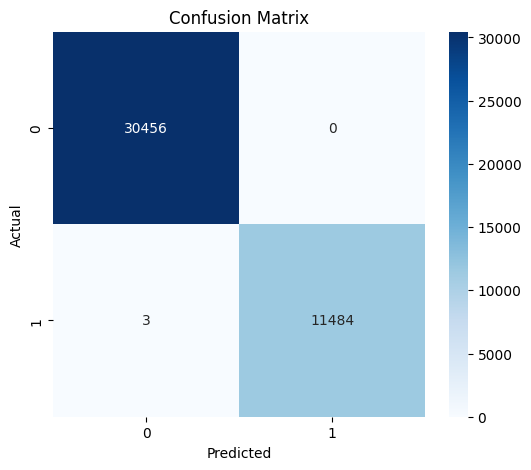

In [13]:
# Evaluate performance
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
